In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2452, done.
remote: Total 2452 (delta 0), reused 0 (delta 0), pack-reused 2452
Receiving objects: 100% (2452/2452), 8.18 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (1538/1538), done.


In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 7.6 MB/s 
     |████████████████████████████████| 1.8 MB 8.5 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 181 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 31.0 MB/s 
     |████████████████████████████████| 63 kB 572 kB/s 
     |████████████████████████████████| 157 kB 69.2 MB/s 
     |████████████████████████████████| 157 kB 53.0 MB/s 
     |████████████████████████████████| 157 kB 48.2 MB/s 
     |████████████████████████████████| 157 kB 50.7 MB/s 
     |████████████████████████████████| 156 kB 72.1 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=356764205de4a2b1a7d470020c767baf390259cc5b3669c4bf9dfd9dd31a8a9a
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created

In [ ]:
!bash ./datasets/download_cyclegan_dataset.sh summer2winter_yosemite

Specified [summer2winter_yosemite]
for details.

--2022-08-25 21:17:28--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/summer2winter_yosemite.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132640856 (126M) [application/zip]
Saving to: ‘./datasets/summer2winter_yosemite.zip’

./datasets/summer2w 100%[===================>] 126.50M  2.32MB/s    in 72s     

2022-08-25 21:18:41 (1.75 MB/s) - ‘./datasets/summer2winter_yosemite.zip’ saved [132640856/132640856]

Archive:  ./datasets/summer2winter_yosemite.zip
   creating: ./datasets/summer2winter_yosemite/trainA/
  inflating: ./datasets/summer2winter_yosemite/trainA/2014-07-01 10:31:48.jpg  
  inflating: ./datasets/summer2winter_yosemite/trainA/2015-07-01 23:43:46.jpg  
  inflating: ./datasets/summer2winter_yosemite/trainA/2014-07-27 2

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid

from PIL import Image
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
seed = 142

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
data_dir = '/content/pytorch-CycleGAN-and-pix2pix/datasets/summer2winter_yosemite'
os.listdir(data_dir)

['trainA', 'trainB', 'testA', 'testB']

In [ ]:
len(os.listdir(os.path.join(data_dir, 'trainA'))), len(os.listdir(os.path.join(data_dir, 'trainB')))

(1231, 962)

In [ ]:
len(os.listdir(os.path.join(data_dir, 'testA'))), len(os.listdir(os.path.join(data_dir, 'testB')))

(309, 238)

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data_dir: str, test: bool=False, tfms=None):
    super(ImageDataset, self).__init__()

    if test:
      dir_a = os.path.join(data_dir, 'testA')
      dir_b = os.path.join(data_dir, 'testB')
    else:
      dir_a = os.path.join(data_dir, 'trainA')
      dir_b = os.path.join(data_dir, 'trainB')

    self.files_a = [os.path.join(dir_a, name) for name in sorted(os.listdir(dir_a))]
    self.files_b = [os.path.join(dir_b, name) for name in sorted(os.listdir(dir_b))]

    # make the number of images of each class the same
    if len(self.files_a) > len(self.files_b):
      self.files_a = self.files_a[:len(self.files_b)]
    else:
      self.files_b = self.files_b[:len(self.files_a)]

    self.tfms = tfms

  def __len__(self):
    return len(self.files_b)

  def __getitem__(self, index):
    file_a = self.files_a[index]
    file_b = self.files_b[index]

    image_a = Image.open(file_a)
    image_b = Image.open(file_b)
    if self.tfms:
      image_a = self.tfms(image_a)
      image_b = self.tfms(image_b)

    return image_a, image_b

In [ ]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
train_tfms = tt.Compose([tt.Resize([256, 256]),
                         tt.RandomHorizontalFlip(p=0.5),
                         tt.RandomVerticalFlip(p=0.2),
                         tt.RandomPerspective(distortion_scale=0.4, p=0.2),
                         tt.CenterCrop(256),
                         tt.ToTensor(),
                         tt.Normalize(*stats),
                         tt.RandomErasing(p=0.2)])
test_tfms = tt.Compose([tt.Resize([256, 256]), tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_ds = ImageDataset(data_dir, test=False, tfms=train_tfms)
test_ds = ImageDataset(data_dir, test=True, tfms=test_tfms)

In [ ]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
def denorm(img_tensors, mean=0.5, std=0.5):
  return img_tensors * std + mean

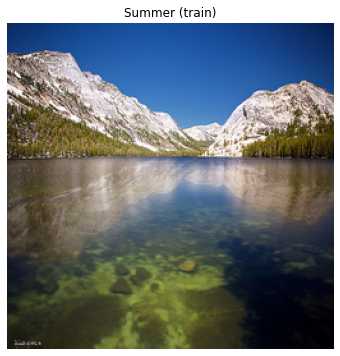

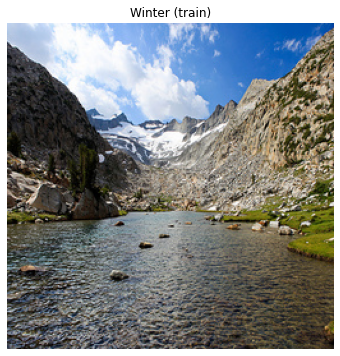

In [ ]:
for batch in train_dl:
  images_a, images_b = batch
  plt.figure(figsize=(20, 6))
  plt.imshow(make_grid(denorm(images_a), nrow=5).permute(1,2,0))
  plt.title('Summer (train)')
  plt.axis('off')

  plt.figure(figsize=(20, 6))
  plt.imshow(make_grid(denorm(images_b), nrow=5).permute(1,2,0))
  plt.title('Winter (train)')
  plt.axis('off')
  break

# Audixilary blocks

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
               transpose=False, use_leaky=True, use_dropout=False, normalize=True):
    super(ConvBlock, self).__init__()
    self.block = []

    if transpose:
      self.block += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                        stride, padding, output_padding=1)]
    else:
      self.block += [nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                               padding, bias=False)]

    if normalize:
      self.block += [nn.InstanceNorm2d(out_channels)]

    if use_dropout:
      self.block += [nn.Dropout(0.5)]

    if use_leaky:
      self.block += [nn.LeakyReLU(negative_slope=0.2, inplace=True)]
    else:
      self.block += [nn.ReLU(inplace=True)]

    self.block = nn.Sequential(*self.block)

  def forward(self, x):
    return self.block(x)

class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.block = nn.Sequential(
        nn.ReflectionPad2d(1),
        ConvBlock(in_channels=channels, out_channels=channels,
                  kernel_size=3, use_leaky=False, use_dropout=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3),
        nn.InstanceNorm2d(channels)
    )

  def forward(self, x):
    return x + self.block(x)

# Generator and Discriminator

In [ ]:
class Generator(nn.Module):
  def __init__(self, in_channels, out_channels, num_residual_blocks=9):
    super(Generator, self).__init__()

    '''Encoder'''
    # Initial layer: 3 x 256 x 256 -> 64 x 256 x 256
    self.initial = [
        nn.ReflectionPad2d(in_channels),
        ConvBlock(in_channels=in_channels, out_channels=64,
                  kernel_size=2*in_channels+1, use_leaky=False)
    ]
    self.initial = nn.Sequential(*self.initial)

    # Downsampling: 64 x 256 x 256 -> 128 x 128 x 128 -> 256 x 64 x 64
    self.down = [
        ConvBlock(in_channels=64, out_channels=128,
                  kernel_size=3, stride=2, padding=1, use_leaky=False),
        ConvBlock(in_channels=128, out_channels=256, kernel_size=3,
                  stride=2, padding=1, use_leaky=False)
    ]
    self.down = nn.Sequential(*self.down)

    '''Transformer'''
    # ResNet: 256 x 64 x 64 -> 256 x 64 x 64
    self.transform = [ResidualBlock(256) for _ in range(num_residual_blocks)]
    self.transform = nn.Sequential(*self.transform)

    '''Decoder'''
    # Unsampling: 256 x 64 x 64 -> 128 x 128 x 128 -> 64 x 256 x 256
    self.up = [
        ConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=2,
                  padding=1, transpose=True, use_leaky=False),
        ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=2,
                  padding=1, transpose=True, use_leaky=False)
    ]
    self.up = nn.Sequential(*self.up)

    # Out layer: 64 x 256 x 256 -> 3 x 256 x 256
    self.out = nn.Sequential(
        nn.ReflectionPad2d(out_channels),
        nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=2*out_channels+1),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.down(self.initial(x))
    x = self.transform(x)
    x = self.out(self.up(x))
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, in_channels):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        # 3 x 256 x 256 -> 64 x 128 x 128
        ConvBlock(in_channels=in_channels, out_channels=64, kernel_size=4,
                  stride=2, padding=1, normalize=False),
        # 64 x 128 x 128 -> 128 x 64 x 64
        ConvBlock(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),

        # 128 x 64 x 64 -> 256 x 32 x 32
        ConvBlock(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),

        # 256 x 32 x 32 -> 512 x 31 x 31
        ConvBlock(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=1),

        # 512 x 31 x 31 -> 1 x 30 x 30
        ConvBlock(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1)
    )
    return None

  def forward(self, x):
    return self.model(x)

In [ ]:
generator_a2b = Generator().to(device)
generator_b2a = Generator().to(device)

discriminator_a = Discriminator().to(device)
discriminator_b = Discriminator().to(device)

# optimizers, schedulers and losses

In [ ]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [ ]:
lr = 2e-4
b1 = 0.5
b2 = 0.999

optim_generators = torch.optim.Adam(
    list(generator_a2b.parameters()) + list(generator_b2a.parameters()),
    lr=lr, betas=(b1, b2)
)

optim_discriminators = torch.optim.Adam(
    list(discriminator_a.parameters()) + list(discriminator_b.parameters()),
    lr=lr, betas=(b1, b2)
)

In [ ]:
num_epochs = 80
decay_epoch = 25

lr_sched_step = lambda epoch: 1 - max(0, epoch - decay_epoch) / (num_epochs - decay_epoch)

lr_sched_generators = torch.optim.lr_scheduler.LambdaLR(optim_generators, lr_lambda=lr_sched_step)
lr_sched_discriminators = torch.optim.lr_scheduler.LambdaLR(optim_discriminators, lr_lambda=lr_sched_step)

# History, buffer

In [ ]:
def get_lr(optim):
  for param_group in optim.param_groups:
    return param_group['lr']

In [ ]:
def update_req_grad(models, requires_grad=True):
  for model in models:
    for param in model.parameters():
      param.requires_grad = requires_grad

In [ ]:
class History():
  def __init__(self):
    self.generators_loss = []
    self.discriminators_loss = []
    self.lrs = []

  def update(self, gen_loss, discr_loss):
    self.generators_loss.append(gen_loss)
    self.discriminators_loss.append(discr_loss)

  def update_lrs(self, lr):
    self.lrs.append(lr)

  def show(self, title='Losses'):
    fig = plt.figure(figsize=(20,9))
    plt.title(title)
    plt.plot(self.generators_loss, 'o-', color='r',
             linewidth=2, markersize=3, label='Generators Loss')
    plt.plot(self.discriminators_loss, 'o-', color='b',
             linewidth=2, markersize=3, label='Discriminators Loss')
    plt.legend(loc='best')
    plt.xlabel('Epoch N.')
    plt.ylabel('Loss score')
    plt.grid(True)
    plt.show();

  def show_lrs(self, title='Learning rates'):
    fig = plt.figure(figsize=(20,9))
    plt.title(title)
    plt.plot(self.lrs,
             linewidth=2, markersize=3)
    plt.xlabel('Batch N.')
    plt.ylabel('Learning rate')
    plt.grid(True)
    plt.show();

In [ ]:
class Buffer():
  def __init__(self, max_images=50):
    self.max_images = max_images
    self.images = []

  def update(self, images):
    images = images.detach().cpu().data.numpy()
    for image in images:
      if len(self.images) < self.max_images:
        self.images.append(image)
      else:
        if np.random.rand() > 0.5:
          index = np.random.randint(0, self.max_images)
          self.images[index] = image

  def sample(self, num_images):
    samples = np.array([self.images[np.random.randint(0, len(self.images))] for _ in range(num_images)])
    return torch.tensor(samples)

In [ ]:
%%time

history = History()
buffer_a = Buffer()
buffer_b = Buffer()

for epoch in range(num_epochs):
  avg_generator_loss = 0
  avg_discriminator_loss = 0

  for i, (real_a, real_b) in enumerate(tqdm(train_dl, leave=False, total=len(dl))):
    real_a, real_b = real_a.to(device), real_b.to(device)

    '''Train generators'''
    # switching models parameters so that only generators are trained
    update_req_grad([generator_a2b, generator_b2a], requires_grad=True)
    update_req_grad([discriminator_a, discriminator_b], requires_grad=False)

    # zero parameters for gradients
    optim_generators.zero_grad()

    # forward pass
    fake_b = generator_a2b(real_a)
    fake_a = generator_b2a(real_b)

    cycle_b = generator_a2b(fake_a)
    cycle_a = generator_b2a(fake_b)

    identity_b = generator_a2b(real_b)
    identity_a = generator_b2a(real_a)

    # update photos that are used to feed up discriminators
    buffer_a.update(fake_a)
    buffer_b.update(fake_b)

    # discriminator outputs that are used in the adversarial loss
    discriminator_outputs_a = discriminator_a(fake_a)
    discriminator_outputs_b = discriminator_b(fake_b)

    # labels that are used as ground truth
    labels_real = torch.ones(discriminator_outputs_a.size()).to(device)
    labels_fake = torch.zeros(discriminator_outputs_a.size()).to(device)

    # adversarial loss - enforces that the generated output to be of appropriate domain
    loss_GAN_a2b = criterion_GAN(discriminator_outputs_b, labels_real)
    loss_GAN_b2a = criterion_GAN(discriminator_outputs_a, labels_real)
    loss_GAN = (loss_GAN_a2b + loss_GAN_b2a) / 2

    # cycle consistency loss = enforces that the input and output are recognazibely the same
    loss_cycle_a = criterion_cycle(cycle_a, real_a)
    loss_cycle_b = criterion_cycle(cycle_b, real_b)
    loss_cycle = (loss_cycle_a + loss_cycle_b) / 2

    # identity mapping loss - helps preserve the color of the input images
    loss_identity_a = criterion_identity(identity_a, real_a)
    loss_identity_b = criterion_identity(identity_b, real_b)
    loss_identity = (loss_identity_a + loss_identity_b) / 2

    # total loss
    loss_generators_total = loss_GAN + 10 * loss_cycle + 5 * loss_identity

    # backward-pass
    loss_generators_total.backward()
    optim_generators.step()

    # limiting gradient norms - if they exceed 100, something went wrong
    clip_grad_norm_(generator_a2b.parameters(), 100)
    clip_grad_norm_(generator_b2a.parameters(), 100)


    '''Train discriminators'''
    # Switching model parametrs so that only discriminators are trained
    update_req_grad([discriminator_a, discriminator_b], True)
    update_req_grad([generator_a2b, generator_b2a], False)

    # zero parameters for gradients
    optim_discriminators.zero_grad()

    # sample images from 50 stored
    fake_a = buffer_a.sample(num_images=batch_size).to(device)
    fake_b = buffer_b.sample(num_images=batch_size).to(device)

    # making labels noisy for discriminators so that they don't prevail over generators
    threshold = min(1, 0.85 + (1 - 0.85) * epoch / (num_epochs // 2))
    noisy_labels_real = (torch.rand(discriminator_outputs_b.size()) < threshold).float().to(device)

    # forward-pass + losses
    loss_real_a = criterion_GAN(discriminator_a(real_a), noisy_labels_real)
    loss_fake_a = criterion_GAN(discriminator_a(fake_a.detach()), labels_fake)
    loss_photo = (loss_real_a + loss_fake_a) / 2

    loss_real_b = criterion_GAN(discriminator_b(real_b), noisy_labels_real)
    loss_fake_b = criterion_GAN(discriminator_b(fake_b.detach()), labels_fake)
    loss_b = (loss_real_b + loss_fake_b) / 2

    loss_discriminators_total = loss_a + loss_b

    # backawrd-bass
    loss_discriminators_total.backward()
    optim_discriminators.step()

    # clipping gradients to avoid gradient explosion
    clip_grad_norm_(discriminator_a.parameters(), 100)
    clip_grad_norm_(discriminator_b.parameters(), 100)

    # update intermediate results
    avg_generator_loss += loss_generators_total.item()
    avg_discriminator_loss += loss_discriminators_total.item()
    last_lr = get_lr(optim_generators)
    history.update_lrs(last_lr)

  # saving intermediate results
  avg_generator_loss /= len(dl)
  avg_discriminator_loss /= len(dl)
  history.update(avg_generator_loss, avg_discriminator_loss)

  # showing intermediate results
  print("Epoch: %d/%d | Generators Loss: %.4f | Discriminators Loss: %.4f | Last lr %.8f"
              % (epoch+1, num_epochs, avg_generator_loss, avg_discriminator_loss, last_lr))
  # showitg  generated pictures
  if (epoch + 1) % 10 == 0:
    sample_real_a, sample_real_b = next(iter(test_dl))

    sample_fake_b = generator_a2b(sample_real_a.to(device)).detach().cpu()
    sample_fake_a = generator_b2a(sample_real_b.to(device)).detach().cpu()
    num_photos = min(batch_size, 5)
    plt.figure(figsize=(20, 8))
    for k in range(num_photos):
      plt.subplot(2, num_photos, k + 1)
      plt.imshow(denorm(sample_real_a[k]).permute(1, 2, 0))
      plt.title('Input photo')
      plt.axis('off')

      plt.subplot(2, num_photos, k + num_photos + 1)
      plt.imshow(denorm(sample_fake_b[k]).permute(1, 2, 0))
      plt.title('Output image')
      plt.axis('off')
    plt.show()
    for k_ in range(num_photos):
      plt.subplot(2, num_photos, k_ + 1)
      plt.imshow(denorm(sample_real_b[k_]).permute(1, 2, 0))
      plt.title('Input photo')
      plt.axis('off')

      plt.subplot(2, num_photos, k + num_photos + 1)
      plt.imshow(denorm(sample_fake_a[k_]).permute(1, 2, 0))
      plt.title('Output image')
      plt.axis('off')
    plt.show()
  lr_sched_generators.step()
  lr_sched_discriminators.step()